### Set Up Environment and Load Data.

In [1]:
import datetime as dt

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
df = pd.read_csv("train.csv")

### Quick EDA

In [3]:
# no nulls, not a ton of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64912 entries, 0 to 64911
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 64912 non-null  object 
 1   OrderID            64912 non-null  object 
 2   CustomerID         64912 non-null  object 
 3   CustomerState      64912 non-null  object 
 4   CustomerBirthDate  64912 non-null  object 
 5   OrderDate          64912 non-null  object 
 6   ProductDepartment  64912 non-null  object 
 7   ProductSize        64912 non-null  object 
 8   ProductCost        64912 non-null  int64  
 9   DiscountPct        64912 non-null  float64
 10  PurchasePrice      64912 non-null  float64
 11  Returned           64912 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 5.9+ MB


In [4]:
df.head(3)

,ID,OrderID,CustomerID,CustomerState,CustomerBirthDate,OrderDate,ProductDepartment,ProductSize,ProductCost,DiscountPct,PurchasePrice,Returned
0,58334388-e72d-40d3-afcf-59561c262e86,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Youth,M,9,0.0356,28.93,0
1,fb73c186-ca70-4eea-b80e-422d732205aa,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1192,44.92,0
2,7590dca6-7344-4a11-ad6e-bd9100730c33,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,XL,20,0.1698,48.98,0


In [5]:
# is our target fairly balanced?
df.Returned.value_counts(dropna=False, normalize=True)

0    0.647569
1    0.352431
Name: Returned, dtype: float64

In [6]:
# how much overlap of carts/items/whatever else do we have?
df.nunique(axis=0)

ID                   64912
OrderID              21178
CustomerID            6300
CustomerState           51
CustomerBirthDate     5270
OrderDate             1741
ProductDepartment        4
ProductSize              7
ProductCost             45
DiscountPct            133
PurchasePrice         2052
Returned                 2
dtype: int64

In [7]:
# PurchasePrice and ProductCost are correlated
df.corr()

,ProductCost,DiscountPct,PurchasePrice,Returned
ProductCost,1.000000,-0.052259,0.795530,0.064411
DiscountPct,-0.052259,1.000000,-0.358613,-0.008783
PurchasePrice,0.795530,-0.358613,1.000000,0.075723
Returned,0.064411,-0.008783,0.075723,1.000000


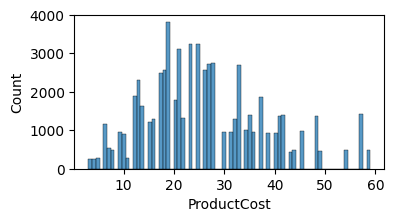

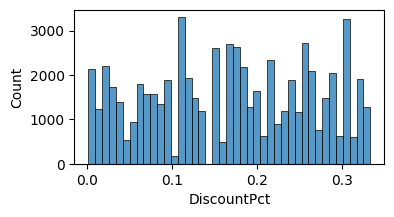

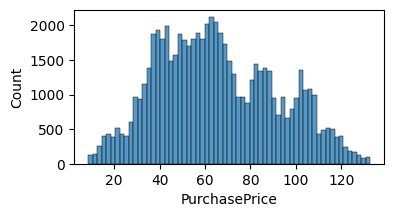

In [8]:
# how normal or uniform are our continuous predictors
for col in ["ProductCost", "DiscountPct", "PurchasePrice"]:
    plt.figure(figsize=(4, 2))
    sns.histplot(df[col])
    plt.show()

In [9]:
# this is messy but I really like to have an idea of how common values are within a feature
for col in df.columns:
    print(df[col].value_counts().head(3))
    print()

58334388-e72d-40d3-afcf-59561c262e86    1
5e966d74-67c5-4f3e-bfb9-a6138164425a    1
b07a53fc-7aa2-4a54-8c69-bb5ae8448d78    1
Name: ID, dtype: int64

7f5f272e-f911-45ad-9d49-384b363f8c1f    14
6647aba2-129b-400a-9d77-832fa85395fc    11
dbc1c0e0-4d8c-412c-8878-d80be20f323f    10
Name: OrderID, dtype: int64

548f1ca0-2381-4972-946e-8f8f6e9db3de    40
48b3fd29-a24e-4114-bab3-f0d2ab828a3f    39
2d6a4060-b499-4dad-bae6-731550521fc8    39
Name: CustomerID, dtype: int64

California    7612
Texas         5455
New York      4002
Name: CustomerState, dtype: int64

1970-05-13    67
1994-12-12    61
1963-09-29    61
Name: CustomerBirthDate, dtype: int64

2019-11-29    313
2017-11-24    279
2018-11-23    252
Name: OrderDate, dtype: int64

Mens      27695
Womens    26922
Youth      6343
Name: ProductDepartment, dtype: int64

L    16588
M    16223
S     9674
Name: ProductSize, dtype: int64

19    3817
23    3250
25    3247
Name: ProductCost, dtype: int64

0.3081    1401
0.0681    1373
0.1186    1210


#### Taking a second to look at ID variables

Checking on if `ID`, `OrderID`, and `CustomerID` are variables that should be included in model as predictors, or if that would create problems. In a real scenario I would not peek at `test.csv` for this information. 

In [10]:
final_test = pd.read_csv("test.csv")

print("Test has ", final_test.ID.nunique(), "records")
print("Test has ", final_test.ID.nunique(), "unique IDs")
print("Test has ", final_test.OrderID.nunique(), "unique Order IDs")
print("Test has ", final_test.CustomerID.nunique(), "unique Customer IDs")

print(
    "Number of Customer IDs that appear in both train and test: ",
    len(
        list(
            set(df.CustomerID.unique()).intersection(
                set(final_test.CustomerID.unique())
            )
        )
    ),
)
print(
    "Numer of Order IDs that appear in both train and test: ",
    len(list(set(df.OrderID.unique()).intersection(set(final_test.OrderID.unique())))),
)
print(
    "Number of IDs that appear in both train and test: ",
    len(list(set(df.ID.unique()).intersection(set(final_test.ID.unique())))),
)

Test has  14809 records
Test has  14809 unique IDs
Test has  4794 unique Order IDs
Test has  3386 unique Customer IDs
Number of Customer IDs that appear in both train and test:  3228
Numer of Order IDs that appear in both train and test:  0
Number of IDs that appear in both train and test:  0


My takeaway is that `CustomerID` could be used directly in the model but `OrderID` and `ID` values should be ignored in their raw forms. I'll focus on their relationship to other data points. I'm a little concerned about data leakage using `CustomerID` but in a real situation we WOULD recognize repeat customers so I'm going to include it. I'm only going to use any of the other two after some feature engineering.

### Feature Engineering and Cleanup

In [11]:
# this function adds all new required variables
def returns_preprocessing(df):
    # Some of these variables might be better if less granular.
    df["OrderMonthYear"] = pd.to_datetime(df["OrderDate"]).dt.to_period("M")
    df["CustomerBirthMonth"] = pd.to_datetime(df["CustomerBirthDate"]).dt.month
    df["CustomerBirthYear"] = pd.to_datetime(df["CustomerBirthDate"]).dt.year
    # instead lets try weekday vs weekend?
    df["OrderDateAsDate"] = pd.to_datetime(df["OrderDate"])
    df["DayOfWeek"] = df["OrderDateAsDate"].dt.weekday
    df["IsWeekend"] = df["DayOfWeek"] >= 5
    # based on pdf I want this
    df["MSRP"] = np.round(df["PurchasePrice"] / (1 - df["DiscountPct"]), decimals=2)
    # not using these raw
    df.drop(columns=["OrderDateAsDate", "OrderDate", "CustomerBirthDate", "DayOfWeek"], inplace=True)
    # some reconfiguring to get these next ones
    cart_sizes = df.groupby(["OrderID"]).agg({"ID": "count"}).reset_index()
    repeat_custs = df.groupby(["CustomerID"]).agg({"OrderID": "count"}).reset_index()
    cart_sizes.columns = ["OrderID", "CartSize"]
    repeat_custs.columns = ["CustomerID", "OrderCount"]
    df = df.merge(cart_sizes, how="left", on="OrderID")
    df = df.merge(repeat_custs, how="left", on="CustomerID")

    df["RepeatCustomer"] = 0
    df.loc[df.OrderCount > 1, "RepeatCustomer"] = 1

    # discussed above, also not being used raw
    df.drop(columns=["OrderID", "CustomerID"], inplace=True)

    return df

In [12]:
df = returns_preprocessing(df)

<AxesSubplot:xlabel='CartSize', ylabel='Count'>

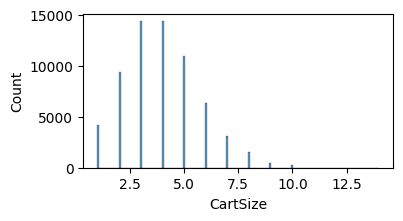

In [13]:
# Do the variables I just created look okay or will they need further transformation?
plt.figure(figsize=(4, 2))
sns.histplot(df.CartSize)

<AxesSubplot:xlabel='OrderCount', ylabel='Count'>

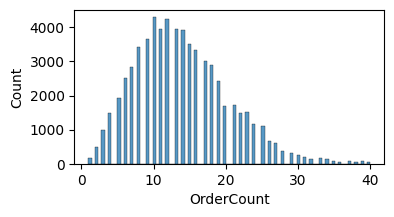

In [14]:
plt.figure(figsize=(4, 2))
sns.histplot(df.OrderCount)

In [15]:
# df.RepeatCustomer.value_counts(dropna=False)

In [16]:
# double check it all looks good
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64912 entries, 0 to 64911
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   ID                  64912 non-null  object   
 1   CustomerState       64912 non-null  object   
 2   ProductDepartment   64912 non-null  object   
 3   ProductSize         64912 non-null  object   
 4   ProductCost         64912 non-null  int64    
 5   DiscountPct         64912 non-null  float64  
 6   PurchasePrice       64912 non-null  float64  
 7   Returned            64912 non-null  int64    
 8   OrderMonthYear      64912 non-null  period[M]
 9   CustomerBirthMonth  64912 non-null  int64    
 10  CustomerBirthYear   64912 non-null  int64    
 11  IsWeekend           64912 non-null  bool     
 12  MSRP                64912 non-null  float64  
 13  CartSize            64912 non-null  int64    
 14  OrderCount          64912 non-null  int64    
 15  RepeatCustomer     

#### Set up column transformation pipeline

In [17]:
# one-hot encode the categorical features
cat_attribs = [
    "CustomerState",
    "CustomerBirthMonth",
    "CustomerBirthYear",
    "OrderMonthYear",
    "ProductDepartment",
    "ProductSize",
    "RepeatCustomer",
    "IsWeekend",
]
# scale the continous features
cont_attribs = [
    "ProductCost",
    "DiscountPct",
    "PurchasePrice",
    "MSRP",
    "CartSize",
    "OrderCount",
]
# make pipeline
pipe = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_attribs),
        ("cont", StandardScaler(), cont_attribs),
    ],
    remainder="passthrough",
)

#### Set Up A Few Functions

In [18]:
# just making these next few to avoid repeating so much code.
# this function is to split dataframe into train and test and transform
# input the dataframe and pipeline, returns all variations of train and test and the column transformer pipeline
def get_training_dfs(df, pipeline):
    # Separate y and X
    y = df["Returned"]
    X = df.drop(["Returned"], axis=1)

    # Get train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4,
    )

    # save all the ids
    id_test = X_test["ID"].copy().reset_index()
    id_train = X_train["ID"].copy().reset_index()
    X_test = X_test.drop(columns=["ID"], axis=1).reset_index(drop=True)
    X_train = X_train.drop(columns=["ID"], axis=1).reset_index(drop=True)

    # fit pipeline with train only
    transformer = pipeline.fit(X_train)

    # apply pipeline to train and test
    X_test = transformer.transform(X_test)
    X_train = transformer.transform(X_train)

    return [id_test, id_train, X_test, X_train, y_test, y_train, transformer]

In [19]:
# this function is to get predictions
# input the model, X values, and y key and return the predictions attached to the y key
def pred_and_return(model, X, id_y):
    # index for X and y must match
    scores = model.predict(X)
    scores = id_y.merge(pd.DataFrame(scores), left_index=True, right_index=True)
    scores.rename(columns={0: "Prediction"}, inplace=True)
    return scores

In [20]:
# this function is to get metrics back for plotting
# input actual and predicted values and get true positive rate, false positive rate, and ROC AUC back
def get_roc_data(actual, pred):
    fpr, tpr, threshold = roc_curve(actual, pred)
    roc_auc = auc(fpr, tpr)
    return [fpr, tpr, roc_auc]

## Models

### XGBoost

In [21]:
mod = xgb.XGBRegressor(objective='binary:logistic',
    gamma=0.5,
    learning_rate=0.05,
    n_estimators=10000,
    max_depth=3,
    colsample_bytree=0.6,
    subsample=0.7,
    random_state = 5
)

In [22]:
id_test, id_train, X_test, X_train, y_test, y_train, transformer = get_training_dfs(df, pipe)

In [23]:
mod.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
             predictor='auto', random_state=5, reg_alpha=0, ...)

Text(0.5, 0, 'False Positive Rate')

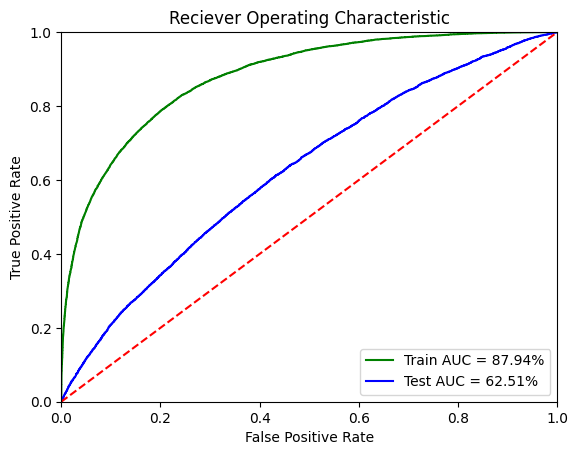

In [24]:
# get predictions
test_scores = pred_and_return(mod, X_test, id_test)
train_scores = pred_and_return(mod, X_train, id_train)

# get metrics
train_roc = get_roc_data(y_train, train_scores.Prediction)
test_roc = get_roc_data(y_test, test_scores.Prediction)

# make roc auc plot
plt.title("Reciever Operating Characteristic")
plt.plot(train_roc[0], train_roc[1], "g")
plt.plot(test_roc[0], test_roc[1], "b")
plt.legend(
    loc="lower right",
    labels=[f"Train AUC = {train_roc[2]:.2%}", f"Test AUC = {test_roc[2]:.2%}"],
)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

In [25]:
# get a basic accuracy score using 0.5 as the probability cutoff
predictions = [round(value) for value in test_scores.Prediction]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.66%


In [26]:
brier_score_loss(y_test, test_scores.Prediction)

0.22355535914459573

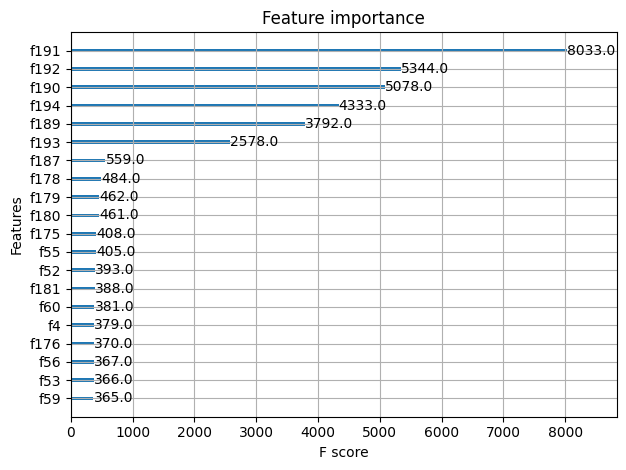

In [27]:
# check if any feature importances stand out
ax = xgb.plot_importance(mod, max_num_features=20)
ax.figure.tight_layout()

### Hyperparameter Tuning

Proceed with caution, depending on parameters this can be very slow.

In [28]:
# %%time
# try gridsearch here
# parameters = {'gamma' : [0.5, 1, 1.5, 2, 5],
#              'subsample' : [0.6, 0.8, 1.0],
#              'colsample_bytree' : [0.6, 0.7,0.8],
#              'max_depth' : [3,4],
#              'learning_rate' : [0.05, 0.01, 0.02]
#              }
# parameters = {'subsample' : [0.6, 0.8],
#              'colsample_bytree' : [0.7,0.8],
#              'max_depth' : [3,4]
#              }

# folds = 4
# param_comb = 8
# skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state=2)

# rand_search = RandomizedSearchCV(mod, param_distributions = parameters, n_iter = param_comb, scoring = 'roc_auc', n_jobs = 4, cv = skf.split(X_train,y_train), verbose = 3, random_state = 2)

# rand_search.fit(X_train,y_train)

# print(rand_search.best_params_)
# print()
# print(rand_search.best_score_)

##  Create Predictions on test.csv

In [29]:
# reload clean
final_df = pd.read_csv("test.csv")
final_df = returns_preprocessing(final_df)
# checks
print(final_df.shape)
final_df.columns

(14809, 16)


Index(['ID', 'CustomerState', 'ProductDepartment', 'ProductSize',
       'ProductCost', 'DiscountPct', 'PurchasePrice', 'Returned',
       'OrderMonthYear', 'CustomerBirthMonth', 'CustomerBirthYear',
       'IsWeekend', 'MSRP', 'CartSize', 'OrderCount', 'RepeatCustomer'],
      dtype='object')

In [30]:
# save the ids
id_final = final_df["ID"].copy().reset_index()
X_final = final_df.drop(columns=["ID"], axis=1).reset_index(drop=True)
# transform columns
X_final = transformer.transform(X_final)

# get and check final predictions
final_scores = pred_and_return(mod, X_final, id_final)
# more checks
print(final_scores.shape)
final_scores.head()

(14809, 3)


,index,ID,Prediction
0,0,a6f6ecd9-2c08-4363-baf7-b54adc35d486,0.060261
1,1,e819be63-7a98-4e6d-b217-03f9ac8c1d03,0.280988
2,2,8936a1c6-f5eb-4c78-9636-e693aae49d9f,0.573883
3,3,68b74b1d-deab-4d93-bfe8-859d450952ef,0.545527
4,4,657abc10-0b36-49df-b3ae-a1a6b9d1d145,0.139139


In [31]:
# save out
final_scores.to_csv("submission.csv", index=False)

## Other Models Tested

### Logistic Regression

In [32]:
# try a barebones logistic regression.
lr_mod = LogisticRegression(class_weight="balanced")
lr_mod = LogisticRegression(
    C=0.05,
    class_weight="balanced",
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    max_iter=100,
    n_jobs=None,
    penalty="l2",
    solver="liblinear",
    tol=0.0001,
    verbose=0,
    warm_start=False,
)

In [33]:
id_test, id_train, X_test, X_train, y_test, y_train, transformer_placeholder = get_training_dfs(df, pipe)

In [34]:
lr_mod.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight='balanced', solver='liblinear')

Text(0.5, 0, 'False Positive Rate')

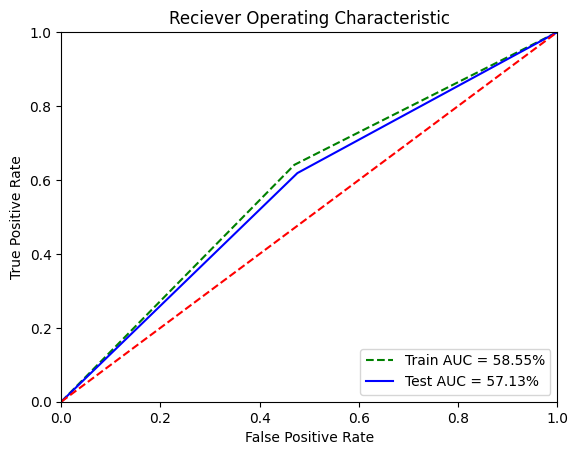

In [35]:
# get predictions
test_scores = pred_and_return(lr_mod, X_test, id_test)
train_scores = pred_and_return(lr_mod, X_train, id_train)
# get metrics
train_roc = get_roc_data(y_train, train_scores.Prediction)
test_roc = get_roc_data(y_test, test_scores.Prediction)
# build plot
plt.title("Reciever Operating Characteristic")
plt.plot(train_roc[0], train_roc[1], "g--")
plt.plot(test_roc[0], test_roc[1], "b")
plt.legend(
    loc="lower right",
    labels=[f"Train AUC = {train_roc[2]:.2%}", f"Test AUC = {test_roc[2]:.2%}"],
)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

In [36]:
# where is it incorrect
confusion_matrix(y_train, train_scores.Prediction)

array([[13390, 11873],
       [ 4913,  8771]], dtype=int64)

In [37]:
print(classification_report(y_train, train_scores.Prediction))

              precision    recall  f1-score   support

           0       0.73      0.53      0.61     25263
           1       0.42      0.64      0.51     13684

    accuracy                           0.57     38947
   macro avg       0.58      0.59      0.56     38947
weighted avg       0.62      0.57      0.58     38947



In [38]:
# get a basic accuracy score with probability cutoff of .5
predictions = [round(value) for value in test_scores.Prediction]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 55.75%


In [39]:
brier_score_loss(y_test, test_scores.Prediction)

0.44251877527440786

### k Nearest Neighbors

In [40]:
# k nearest neighbors
neigh = KNeighborsClassifier()

In [41]:
id_test, id_train, X_test, X_train, y_test, y_train, transformer_placeholder = get_training_dfs(df, pipe)

In [42]:
# train model
neigh.fit(X_train, y_train)

KNeighborsClassifier()

C:\Users\erick\AppData\Local\Temp\ipykernel_5244\2376776495.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(


Text(0.5, 0, 'False Positive Rate')

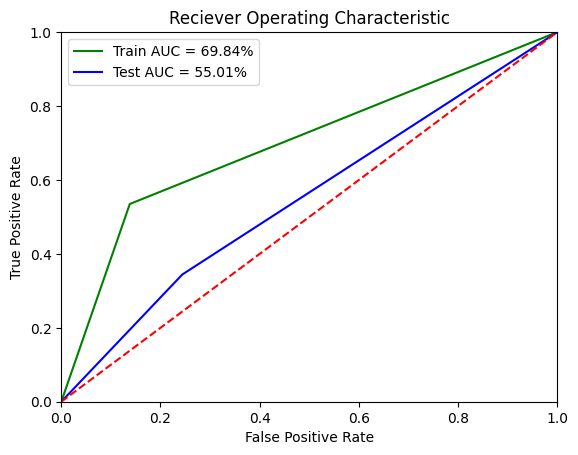

In [43]:
# get predictions
test_scores = pred_and_return(neigh, X_test, id_test)
train_scores = pred_and_return(neigh, X_train, id_train)
# get metrics
train_roc = get_roc_data(y_train, train_scores.Prediction)
test_roc = get_roc_data(y_test, test_scores.Prediction)
# plot
plt.title("Reciever Operating Characteristic")
plt.plot(train_roc[0], train_roc[1], "g")
plt.plot(test_roc[0], test_roc[1], "b")
plt.legend(
    "lower right",
    labels=[f"Train AUC = {train_roc[2]:.2%}", f"Test AUC = {test_roc[2]:.2%}"],
)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

In [44]:
# basic accuracy score with 0.5 as probability cutoff
predictions = [round(value) for value in test_scores.Prediction]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.12%


In [45]:
brier_score_loss(y_test, test_scores.Prediction)

0.38875409204698635